# 1 Строить ROC-AUC
## каждые несколько шагов
### Градиентного спуска
Хммм, у меня же уже есть моя личная логистическая регрессия, буду ей пользоваться, хоть она и отвратительна)

In [105]:
import sys
sys.path.insert(1, '../03_LogReg/HW')
import classiFIRE as FIRE
from IPython import display

In [106]:

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from  sklearn.preprocessing import StandardScaler

In [107]:
data = pd.read_csv('../03_LogReg/HW/winequality-red.csv', sep=';')
q_thrh = data['quality'].quantile(0.5)
data['quality'] = data['quality'].apply(lambda x: 1 if x >= q_thrh else -1)
x = data.drop(columns=['quality']).values
y = data['quality'].values

sc = StandardScaler()
sc.fit(x)
x_sc = sc.transform(x)

In [108]:
clf_fire = FIRE.classiFIRE()
clf_fire.fit(x_sc, y, learning_rate=5e-5, tol=1e-3, batch_size=0.2)
y_hat = clf_fire.predict_proba(x_sc)[: , 1]

In [109]:
fpr, tpr, _ = roc_curve(y, y_hat)
roc_auc = auc(fpr, tpr)

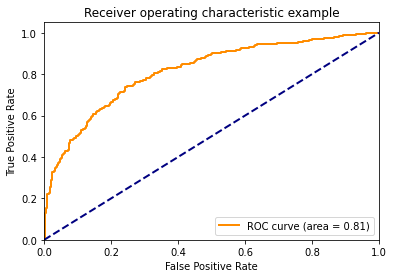

In [110]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Отлично, результат есть, теперь делаем это итеративно

In [111]:
%matplotlib inline

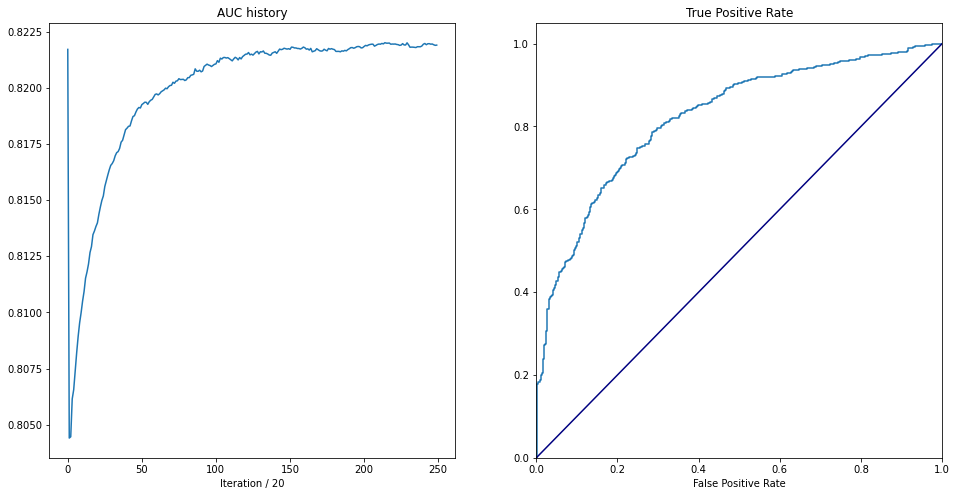

In [114]:
n_iter = 20
n_loops = 250
plt.figure()
clf_fire = FIRE.classiFIRE()
plt.ion()
auc_h = []
for i in range(n_loops):
    
    clf_fire.fit(x_sc, y, learning_rate=5e-5, tol=0, batch_size=0.2, n_iter=n_iter)
    y_hat = clf_fire.predict_proba(x_sc)[: , 1]
    roc_auc = auc(fpr, tpr)
    auc_h.append(roc_auc)
    fpr, tpr, _ = roc_curve(y, y_hat)
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    display.clear_output(wait=True)
    ax[0].plot(auc_h, label='AUC')
    ax[0].set_xlabel(f'Iteration / {n_iter}')
    ax[0].set_title('AUC history')
    ax[1].plot(fpr, tpr, label='ROC curve')
    ax[1].plot([0, 1], [0, 1], color='navy')
    ax[1].set_xlabel(f'False Positive Rate')
    ax[1].set_title('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

Ахаха ROC почти не меняется)

Если делать `Run All`, то это статичная картинка)

# 2 Наилучшая константа
## Для лог рег

Два задания назад я написал функцию ошибки
$$ Q(y, \pi(x))= \sum_{i=0}^{n}(y_i \ln(\pi(x_i) + (1-y_i)\ln(1-\pi(x_i))$$
Но теперь у нас не $\pi(x)$, а $\alpha$.


$$ Q(\vec{y}, \alpha)= \sum_{i=0}^{n}(y_i \ln(\alpha) + (1-y_i)\ln(1-\alpha)$$
Впринципе понятно, в каком направлении работать - брать производную по $\alpha$ и приравнивать к нулю


$$ \frac{d Q(\vec{y} \alpha)}{d\alpha} = \sum_{i=0}^{n}\frac{y_i}{\alpha} + \sum_{i=0}^{n} \frac{1 - y_i}{1 - \alpha} \cdot (-1)=\sum_{i=0}^{n} \frac{y_i (1-\alpha) + \alpha (y_i - 1)}{\alpha(1-\alpha)} = \sum_{i=0}^{n} \frac{y_i - \alpha}{\alpha(1-\alpha)}$$

Не будем рассматривать $\alpha = 0$ или $\alpha = 1$
$$\alpha = \frac{1}{n}\sum_{i=0}^{n}y_i$$
Напомню, что $y_i \in \{0,\ 1\}$

# 3 Задачка про 2 класса треугольника
## И классификатор по одной переменной
### И как результат зависит от сдвига

Вот у нас есть пространство 2х переменных, 2 класса - синий и жёлтый. Там где оба класса - зелёный т.к. синий + жёлтый = зелёный.

Пуская оба класса распределны равномерно с $f(\vec{x}) = 2$, если $\vec{x}$ в треугольнике для каждого класса. Прлучается в зелёном треугольнике двойная концентрация.
<img src="triangles.png">

Красная линий - наша попытка построить разделяющую прямую. Посмотрим, как будут меняться метрики в зависимости от положения этой прямой.

Смотреть будм исключительно аналитически

Пускай жёлтый класс - `Positive`.
Не знаю что можно сделать, кроме как построить confusion matrix в ячейках которой зависимость от $\alpha$ - значения $x_1$ по которому происходит отсечка
<table>
    <tr>
        <td>
\begin{eqnarray}
\\
Actual: 1\\
Actual: 0\\
\end{eqnarray}
        </td>
        <td>
\begin{eqnarray}
Predicted: 1 \\
\alpha - \frac{1}{2}\alpha^2\\
\frac{1}{2}\alpha^2\\
\end{eqnarray}
        </td>
        <td>
\begin{eqnarray}
Predicted: 0 \\
\frac{1}{2} - \alpha + \frac{1}{2}\alpha^2\\
\frac{1}{2} - \frac{1}{2}\alpha^2\\
\end{eqnarray}
        </td>
    </tr>
</table>

Подсказка как производить в 2 раза меньше вычислений при заполнении мтарицы - сумма по строкам мера множества калсса

$$Accuracy = \frac{T_p + T_n}{T_p + T_n + T_n + F_p} = \frac{\alpha - \frac{1}{2}\alpha ^ 2 + \frac{1}{2} - \frac{1}{2}\alpha^2}{\frac{1}{2} + \frac{1}{2}} = \frac{1}{2} + \alpha - \alpha ^ 2$$
$$Recall = \frac{T_p}{T_p + F_p} = \frac{a - \frac{1}{2}\alpha^2}{a - \frac{1}{2}\alpha^2 + \frac{1}{2}-\alpha + \frac{1}{2}\alpha} = \frac{a - \frac{1}{2}\alpha^2}{\frac{1}{2}}$$
$$Precision = \frac{T_p}{T_p + F_p} = \frac{\alpha - \frac{1}{2}\alpha^2}{\alpha - \frac{1}{2}\alpha^2 + \frac{1}{2}\alpha ^ 2} = \frac{\alpha - \frac{1}{2}\alpha^2}{\alpha}$$
$$F_1 = 2\frac{Pre * Rec}{Pre + Rec}$$

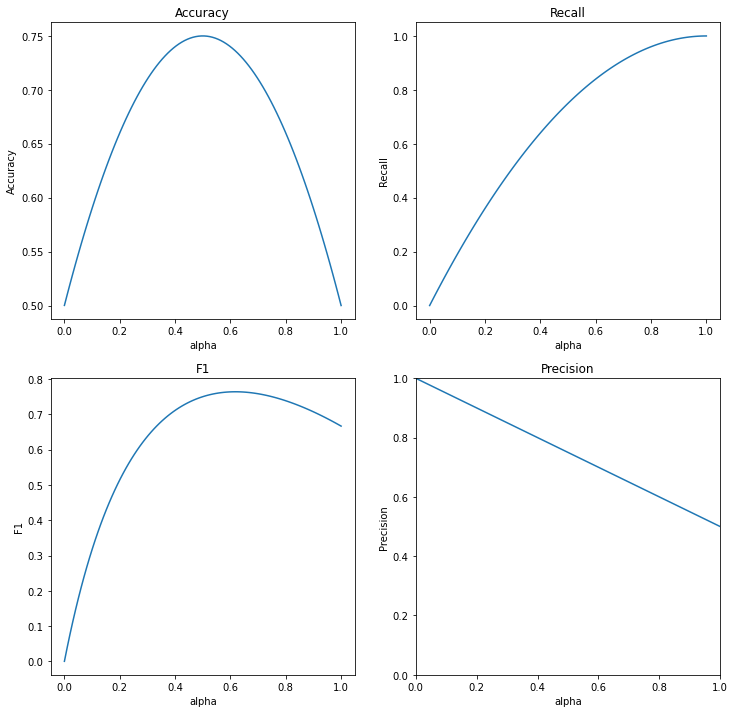

In [137]:
alphas = np.linspace(1e-4, 1, 100)
f1_th = []
acc_th = []
rec_th = []
pre_th = []
for a in alphas:
    t_p = a - 0.5 * a * a
    t_n = 0.5 - 0.5 * a * a
    f_n = 0.5 - a + 0.5 * a * a
    f_p = 0.5 * a * a
    
    acc_th.append(0.5 + a - a * a)
    rec_th.append((a - 0.5 * a * a)/(0.5))
    pr.append(t_p / (t_p + f_p))
    pre_th.append((a - 0.5 * a * a)/(a))
    f1_th.append(2 * pre_th[-1] * rec_th[-1] / (rec_th[-1] + pre_th[-1]))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax[0][0].plot(alphas, acc_th)
ax[0][0].set_ylabel(f'Accuracy')
ax[0][0].set_xlabel('alpha')
ax[0][0].set_title('Accuracy')
#
ax[0][1].plot(alphas, rec_th)
ax[0][1].set_ylabel(f'Recall')
ax[0][1].set_xlabel('alpha')
ax[0][1].set_title('Recall')
#
ax[1][0].plot(alphas, f1_th)
ax[1][0].set_ylabel(f'F1')
ax[1][0].set_xlabel('alpha')
ax[1][0].set_title('F1')
#
ax[1][1].plot(alphas, pre_th)
ax[1][1].set_ylabel(f'Precision')
ax[1][1].set_xlabel('alpha')
ax[1][1].set_title('Precision')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()